In [51]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
import numpy as np
import matplotlib.pylab as plt
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from tqdm import tqdm, trange

In [52]:
def circuit(params,shots):

    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    for layer in range(layers):
        for qubit in range(n_qubits):
            qc.rx(params[qubit][layer][0],qubit)
            qc.ry(params[qubit][layer][1],qubit)
        if(layer<layers-1):
            qc.cx(0,1)
            qc.cx(1,0)
            
    qc.measure_all()
    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all u1, u2, u3, cx gates
    error1 = depolarizing_error(0.001, 1)
    error2 = depolarizing_error(0.01, 2)
    noise_model.add_all_qubit_quantum_error(error1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error2, ['cx'])
    
    backend_sim = QasmSimulator()
    job = execute(qc, backend_sim, basis_gates=noise_model.basis_gates,
     noise_model=noise_model, shots=shots)
    counts = job.result().get_counts()

    return counts

In [53]:
def cost(params,shots,target_state):
    
    counts=circuit(params,shots)

    # the error is designed to prioritize the minimisation of population in 00, 11 states, and
    # equalize the population of 01, 10 states
    error = (abs(target_state['10']-counts.get('10',0))+abs(target_state['01']-counts.get('01',0))
        +2*abs(target_state['00']-counts.get('00',0))+2*abs(target_state['11']-counts.get('11',0)))/200

    error += 1.5*(abs(counts.get('10',0)-counts.get('01',0)))/200  

    return error

Quantum Gradient:

$$\frac{df}{d\theta }\,=\,\frac{1}{2}\,\left( f\left(\theta +\frac{\pi }{2} \right)-f\left(\theta -\frac{\pi }{2} \right) \right)$$

$\theta$ is the weights and $f$ is quantum unitary gate. 

In [54]:
def gradient(params,shots,target_state):

    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi
                    
                F2 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [55]:
def optimize(params,shots,target_state,lr):
    g = gradient(params,shots,target_state)
    params = params - (lr*g)
    return params

In [59]:
np.random.seed(5) #to be reproducible 
params = np.random.rand(2,2,2) #(n_qubits,n_layers,n_weights)
target_state={'00': 0, '01': 50, '10': 50, '11': 0}
shots=100
loss = np.inf
lr = 0.25
test_loss = []
epochs = 300

for it in trange(epochs):
    params = optimize(params,shots,target_state,lr)
    res = cost(params,shots,target_state)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res <= loss:
        loss = res
        var = params

100%|██████████| 300/300 [01:32<00:00,  3.24it/s]


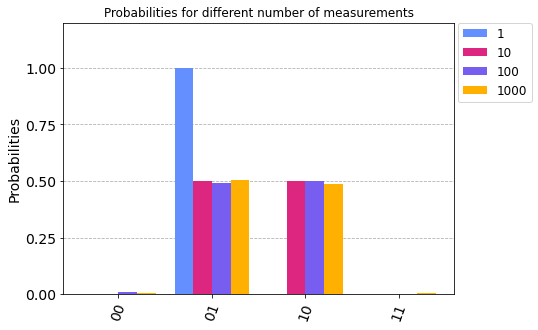

In [70]:
#testing the model (Running this block produces different result everytime just like the outcome of a probabilistic event)
from qiskit.visualization import *
counts1 = circuit(var, 1) 
counts10 = circuit(var, 10)
counts100 = circuit(var, 100)
counts1000 = circuit(var, 1000)
plot_histogram([counts1,counts10,counts100, counts1000],legend=['1','10','100','1000'], title="Probabilities for different number of measurements", bar_labels=False)